In [72]:
%matplotlib inline

import matplotlib
import autograd.numpy as np
import matplotlib.pyplot as plt
import random
import math
from autograd import grad

In [73]:
def generateChevronData():
    xBounds = [-50, 50]
    yBounds = [-50, 50]
    totalPoints = 100
    
    points = []
    targets = []
    
    for i in range(0, totalPoints):
        x = random.randint(xBounds[0], xBounds[1])
        y = random.randint(yBounds[0], yBounds[1])
        
        if x >= y and x <= -y:
            points.append([1, x/50.0,y/50.0])
            targets.append(0)
        else:
            points.append([1, x/50.0,y/50.0])
            targets.append(1)
        
    return np.array(points), np.array(targets)
    
def plotScatter(points):
    xs = [x[1] for x in points]
    ys = [y[2] for y in points]
    
    plt.scatter(xs, ys)

In [135]:
def logLoss(weights):
    predictions = logisticPrediction(weights, points)
    probs = predictions * targets + (1 - predictions) * (1 - targets)
    return -(1/len(points)) * np.sum(np.log(probs))
    
def logisticPrediction(weights, inputs):
    return sigmoid(np.dot(inputs, weights))

def sigmoid(t):
    return 0.5 * (np.tanh(t) + 1)
#     return 1.0/(1.0 + np.exp(-t))

def trainBasicPerceptron():
    weights = np.array([0.0, 0.0, 0.0])
    trainingGradient = grad(logLoss)
    
    print("Initial Loss: ", logLoss(weights))
    for i in range(1, 100):
        weights -= trainingGradient(weights) * 0.01
            
    print("Trained Loss: ", logLoss(weights))    
    print("Weights: ", weights)
    return weights
    
    

Type 0:  35
Type 1:  65
Training Basic Perceptron
Initial Loss:  0.69314718056
Trained Loss:  0.545046978607
Weights:  [ 0.20708965  0.03437634  0.31675767]


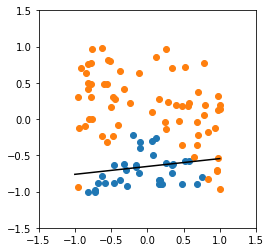

In [136]:

random.seed(1234)
points, targets = generateChevronData()

plt.axis([-1.5, 1.5, -1.5, 1.5])

# Plot points on graph
c1 = []
c2 = []

for i in range(0, len(points)):
    if targets[i] == 0:
        c1.append(points[i])
    else:
        c2.append(points[i])

print("Type 0: ", len(c1))
print("Type 1: ", len(c2))
        
plotScatter(c1)
plotScatter(c2)

print("Training Basic Perceptron")
basicPerceptronWeights = trainBasicPerceptron()
byas = -1 * basicPerceptronWeights[0]/basicPerceptronWeights[2]
Xcoef = basicPerceptronWeights[1]/basicPerceptronWeights[2]

plt.plot([-1.0, 1.0], [-1*Xcoef + byas, Xcoef + byas], 'k-')
plt.gca().set_aspect('equal')

plt.show()

# Boundary Hunter
Here we explore training a perceptron that rather than solving the global optima would rather place its self somewhere useful in the data. For this problem we change our representation of a perceptron to be a point (x,y) plus a gradient m. This is what defines our line. Esentially what we are wanting to do is to solve for local optima in the global sense but a global optima local to (x,y),m.

## Solution 1 (Distance Scaled Error)
A first naive solution to this problem was to adjust the classification error of a data point based on distance from (x,y). While initially it would seem like this should work the issue here is that this loss function dosnt encourage the perceptron to move towards an interesting area, it can find a better solution by moving away from the datapoints it is getting wrong.

## Solution 2 (Maximize Variance Of Local Targets)
A second naive solution is to maximize the variance of the targets in a local area to (x,y). This makes sense as we want to position our self in an interesting place in the data. However the issue is aparent when we look at the graph above. We see that one place we want a line is on the left side of the "chevron" but in this area there is alot of blue but not alot of orange so this solution wouldent even work in our simple proof of concept example.

## Solution 3 (Global and Local Minimization)
As discussed above we are trying to find a local (sub optimal) global solution and a global (optimal) local solution (local to (x,y),m). This approach takes our loss $L$ to be $L_G + L_L$ where $L_G$ is the standard cross entropy loss that a standard perceptron would use and $L_L$ is the standard cross entropy loss but as a distance scaled error.

So define $ E(i) = t_i log(\hat{t_i}) + (1-t_i) log(\hat{t_i}) $, then
$L = \sum_{i=1}^{N} E(i) * (1 + d_i)$ where $d_i$ is the distance from the point to $(x,y)$. After experementing with this I found that while the point does move often the optimal solution has a gradient very close to 0. Looking at the origonal perceptron, given that the solution has a very slight gradient, I think that $L_G$ is having to much of an effect on the total loss


# Simplyfy Problem
Solution 3 seemed close but there is still something wrong with the approach, We break the problem down and start by fixing the point $(x,y)$ and solving for the gradient of the line.

Initial Loss:  1.39034136371
Trained Loss:  1.17150239243
Weights:  [ 0.78731958]


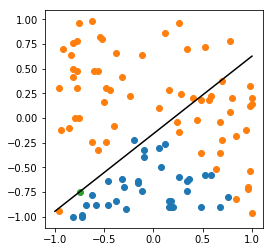

In [152]:
plotScatter(c1)
plotScatter(c2)

X = -0.75
Y = -0.75

def fixedXLogLoss(weights):
    distances = np.sqrt(np.array(list(map(lambda x: ((x[0] - X)**2 + (x[1] - Y)**2), points))))
    maxD = np.max(distances)
    normD = 1.001 - (distances/maxD)
    
    predictions = fixedXLogisticPredict(weights, points)
    probs = predictions * targets + (1 - predictions) * (1 - targets)
    t = np.array(list(map(lambda x: (probs[x]) * (1 + normD[x]), range(0, len(distances)))))
    return -(1/len(points)) * np.sum(np.log(t))

def fixedXLogisticPredict(weights, inputs):
    ins = np.array(list(map(lambda x: fixedXPredict(weights, x), inputs)))
    return sigmoid(ins)

def fixedXPredict(weights, i):
    return (Y - i[2]) - weights[0] * (X - i[1])

def solveGradientForFixedX():
    weights = np.array([0.0])
    trainingGradient = grad(fixedXLogLoss)
    
    print("Initial Loss: ", fixedXLogLoss(weights))
    for i in range(1, 3000):
        weights -= trainingGradient(weights) * 0.003
            
    print("Trained Loss: ", fixedXLogLoss(weights))    
    print("Weights: ", weights)
    return weights
    

fixedWeightsX = solveGradientForFixedX()

plt.scatter(X, Y)
plt.plot([-1.0, 1.0], [Y - fixedWeightsX[0]*(X + 1), Y - fixedWeightsX[0]*(X - 1)], 'k-')

plt.gca().set_aspect('equal')
plt.show()

Using this setup we see that with carful positioning of the initial (x,y) we are able to solve for a line gradient which achives the goal we are looking for. We want to be add in solving for the (x,y) position aswell.

In [137]:
def trainBoundarySeekerPerceptron():
    # Start at the origin with gradient 0 
    weights = np.array([1, 0.9, 0.9])
    trainingGradient = grad(localLogLoss)
    
    print("Initial Loss: ", localLogLoss(weights))
    for i in range(1, 100):
        weights -= trainingGradient(weights) * 0.03
            
    print("Trained Loss: ", localLogLoss(weights))    
    print("Weights: ", weights)
    return weights
    
def pgLogisticPrediction(weights, inputs):
    ins = np.array(list(map(lambda x: predict(weights, x), inputs)))
    return sigmoid(ins)
    
def predict(weights, i):
    return (weights[2] - i[2]) - weights[0] * (weights[1] - i[1])
    
def localLogLoss(weights):
#     i = list(filter(lambda e: (points[e][1] - weights[1])**2 + (points[e][2] - weights[2])**2 <= 0.4**2, range(0, len(points))))
    
#     local = np.array(list(map(lambda x: points[x], i)))
#     t = np.array(list(map(lambda x: targets[x], i)))
    distances = np.sqrt(np.array(list(map(lambda x: ((x[0] - weights[1])**2 + (x[1] - weights[2])**2), points))))
    maxD = np.max(distances)
    normD = 1.001 - (distances/maxD)
    
    predictions = pgLogisticPrediction(weights, points)
    probs = predictions * targets + (1 - predictions) * (1 - targets)
    t = np.array(list(map(lambda x: (probs[x]) * (1 + normD[x]), range(0, len(distances)))))
    return -(1/len(points)) * np.sum(np.log(t))



Training Boundary Hunter Perceptron
Initial Loss:  0.978022701288
Trained Loss:  0.8105912563
Weights:  [ 0.3995008   0.98213335  0.68137695]


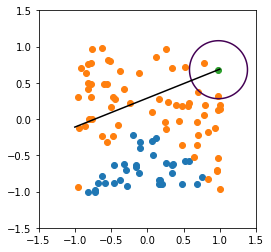

In [138]:
plotScatter(c1)
plotScatter(c2)

print("\n\nTraining Boundary Hunter Perceptron")
# r1 = 0.25
# r2 = 0.5
c = 0.4
modifiedPerceptronWeights = trainBoundarySeekerPerceptron()
plt.scatter(modifiedPerceptronWeights[1], modifiedPerceptronWeights[2])
plt.plot([-1.0, 1.0], [modifiedPerceptronWeights[2] - modifiedPerceptronWeights[0]*(modifiedPerceptronWeights[1] + 1), modifiedPerceptronWeights[2] - modifiedPerceptronWeights[0]*(modifiedPerceptronWeights[1] - 1)], 'k-')

x = np.linspace(-1.5, 1.5, 500)
y = np.linspace(-1.5, 1.5, 500)
X, Y = np.meshgrid(x,y)
F = ((X - modifiedPerceptronWeights[1]))**2 + ((Y - modifiedPerceptronWeights[2]))**2 - c**2
plt.contour(X,Y,F,[0])

plt.gca().set_aspect('equal')

plt.show()